In [1]:
import os
import sys

import numpy as np
import pandas as pd

import torch
from matplotlib import pyplot as plt

In [2]:
import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets.folder import default_loader

In [3]:
import argparse
import datetime
import json
import numpy as np
import os
import time
from pathlib import Path

In [4]:
import timm

In [5]:
import models_mae
import models_mae_pvt
import models_mae_swin
import models_simmim_pvt
import models_simmim_swin

In [6]:
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

In [7]:
from torch.utils.data import Dataset
from glob import glob
import cv2 as cv
from PIL import Image

In [8]:
from engine_pretrain import train_one_epoch
from mask_transform import MaskTransform

In [9]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = list(glob(main_dir+'/*.png'))
        self.total_imgs = all_imgs

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = self.total_imgs[idx]
        image = Image.open(img_loc).convert("RGB")
#         image = torch.from_numpy(image).float()
        tensor_image, tensor_mask = self.transform(image)
        return tensor_image, tensor_mask

In [10]:
args = type('args', (), {})()
args.input_size = 256
args.token_size = 16
args.mask_ratio = 0.7
args.model = 'simmim_pvt_small_256'
args.norm_pix_loss = False

In [11]:
transform_train = MaskTransform(args)
    # TODO modify your own data loader here
#     train_folder = os.path.join(args.data_path, 'train')
train_folder = './../data_ready/'

#     train_ann_file = os.path.join(args.data_path, 'train.txt')
dataset_train = CustomDataSet(train_folder, transform=transform_train)

/opt/conda/lib/python3.6/site-packages/torchvision/transforms/transforms.py:853: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [12]:
batch = dataset_train[20]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


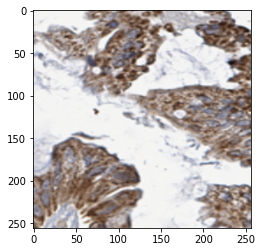

In [13]:
plt.imshow(batch[0].permute((1, 2, 0)) * np.array(IMAGENET_DEFAULT_STD).reshape((1, 1, -1)) + np.array(IMAGENET_DEFAULT_MEAN).reshape((1, 1, -1)))
plt.show()

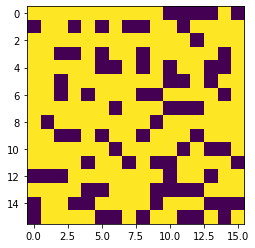

In [14]:
plt.imshow(batch[1].reshape(16, 16))
plt.show()

In [15]:
model = models_simmim_pvt.__dict__[args.model](norm_pix_loss=args.norm_pix_loss)

In [27]:
model.load_state_dict(torch.load('./../output_dir/checkpoint-899.pth')['model'])

<All keys matched successfully>

In [28]:
device = 'cuda:3'

In [29]:
model = model.to(device)
_ = model.eval()

In [30]:
batch[0].shape, batch[1].shape

(torch.Size([3, 256, 256]), (256,))

In [31]:
samples = batch[0].unsqueeze(0).to(device, non_blocking=True)
bool_masked_pos = torch.tensor(batch[1][None, :]).to(device, non_blocking=True).flatten(1).to(torch.bool)

loss, p, g = model(samples, mask=bool_masked_pos)

In [32]:
loss

tensor(0.4965, device='cuda:3', grad_fn=<MeanBackward0>)

In [33]:
p.shape

torch.Size([1, 256, 768])

In [34]:
g.shape

torch.Size([1, 256])

In [35]:
p = model.unpatchify(p)

In [36]:
p = p[0].permute((1, 2, 0)).detach().cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


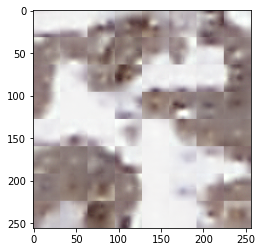

In [37]:
plt.imshow(p * np.array(IMAGENET_DEFAULT_STD).reshape((1, 1, -1)) + np.array(IMAGENET_DEFAULT_MEAN).reshape((1, 1, -1)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


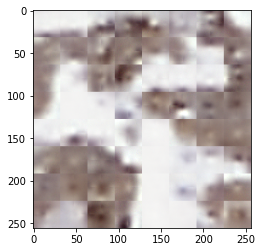

In [26]:
plt.imshow(p * np.array(IMAGENET_DEFAULT_STD).reshape((1, 1, -1)) + np.array(IMAGENET_DEFAULT_MEAN).reshape((1, 1, -1)))
plt.show()

In [69]:
8*16

128